<a href="https://colab.research.google.com/github/AtSourav/Beta-VAE-on-MNIST/blob/main/MNIST_beta1_noreg_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [ ]:
input_size = (14,14,1)
latent_dim = 2
batch_size = 64

# **Loading the dataset**

In [ ]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)


print(img_train.shape)
print(img_valid.shape)

img_train = img_train/255.
img_valid = img_valid/255.


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [ ]:
# l2_reg = keras.regularizers.L2(l2=0.01)

# **Defining the model**

In [ ]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(10, 3, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(30, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(50, 2, padding="valid")(x)
x = layers.ReLU()(x)


x = layers.Flatten()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 12, 10)           100       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 6, 6, 10)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 re_lu (ReLU)                (None, 6, 6, 10)             0         ['max_pooling2d[0][0]'] 

In [ ]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(1*32)(latent_input)
x = layers.ReLU()(x)
x = layers.Reshape((1,1,32))(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1, 2, strides=2, activation='sigmoid',padding='same')(x)

decoder_output = x

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 re_lu_4 (ReLU)              (None, 32)                0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 32)          4128      
 anspose)                                                        
                                                                 
 re_lu_5 (ReLU)              (None, 2, 2, 32)          0         
                                                           

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [ ]:
decoder_out = decoder(encoder(encoder_input)[2])
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               7824      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         6841      
                                                                 
Total params: 14665 (57.29 KB)
Trainable params: 14665 (57.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Defining the loss**

In [ ]:
beta = 1

def vae_loss(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

# **Training**

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=500000, decay_rate=0.996, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=150, steps_per_epoch=None)


Epoch 1/150
938/938 [==============================] - 39s 33ms/step - loss: 57.9335 - val_loss: 49.9594
Epoch 2/150
938/938 [==============================] - 22s 24ms/step - loss: 49.5566 - val_loss: 49.2117
Epoch 3/150
938/938 [==============================] - 21s 22ms/step - loss: 49.0407 - val_loss: 48.7938
Epoch 4/150
938/938 [==============================] - 24s 25ms/step - loss: 48.5785 - val_loss: 47.7170
Epoch 5/150
938/938 [==============================] - 25s 26ms/step - loss: 47.2361 - val_loss: 46.8026
Epoch 6/150
938/938 [==============================] - 24s 25ms/step - loss: 46.6642 - val_loss: 46.4918
Epoch 7/150
938/938 [==============================] - 26s 27ms/step - loss: 46.3605 - val_loss: 46.2445
Epoch 8/150
938/938 [==============================] - 24s 26ms/step - loss: 46.1626 - val_loss: 46.0761
Epoch 9/150
938/938 [==============================] - 23s 24ms/step - loss: 45.9774 - val_loss: 45.8342
Epoch 10/150
938/938 [==============================] -

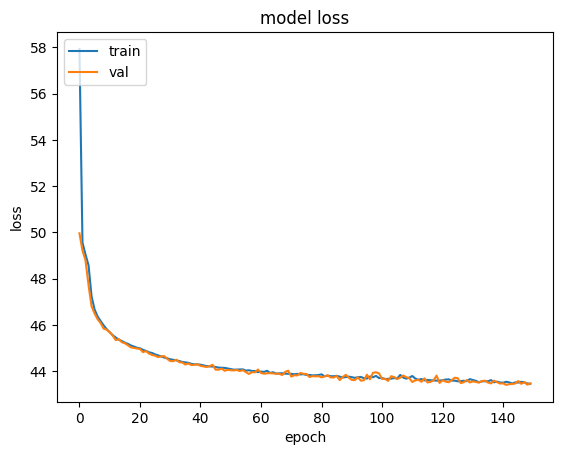

In [ ]:
plt.plot(history.history['loss'] )         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Visualizing the latent space**

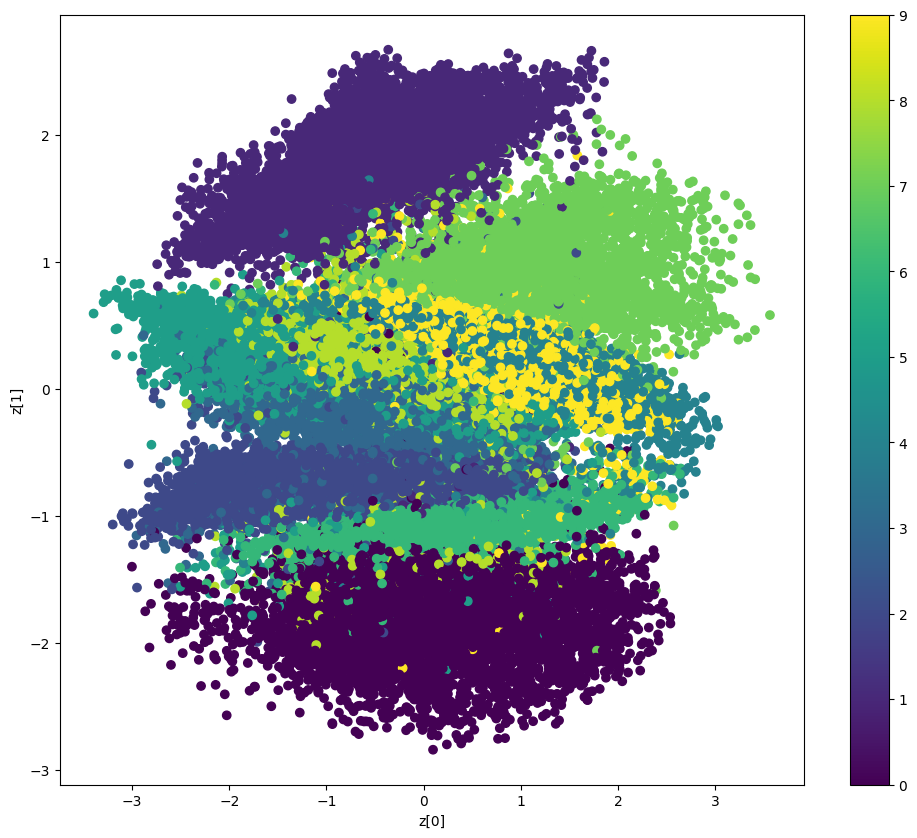

In [ ]:
def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



plot_label_clusters(encoder, img_train,tg_train)       # gives the distribution of z_mean in the latent space, corresponding to different image classes (digits)


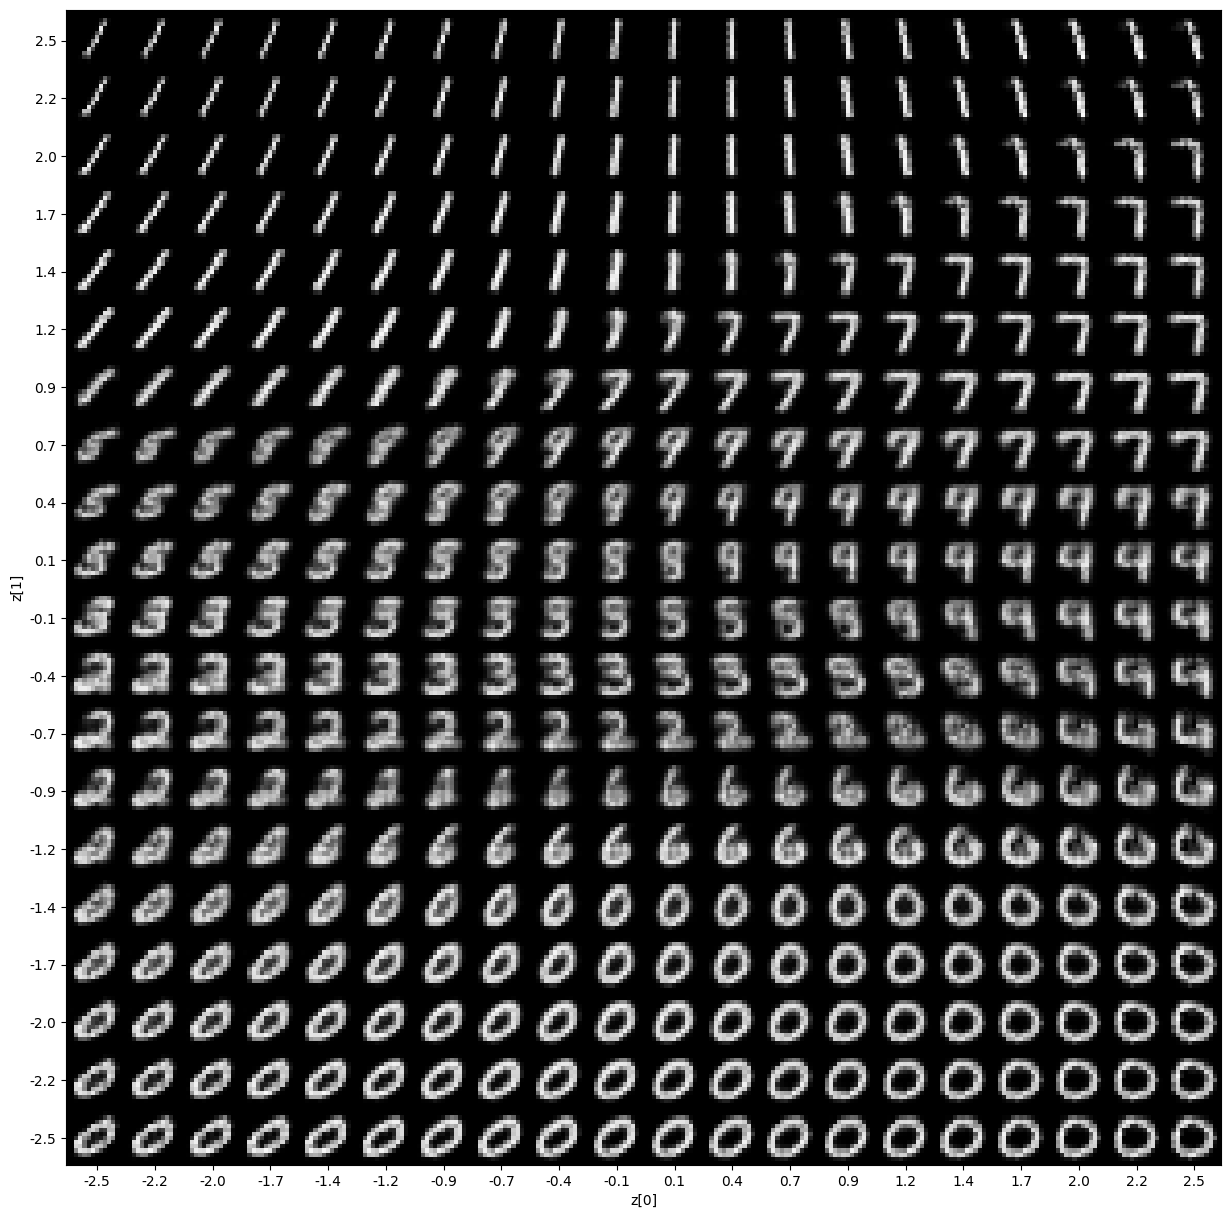

In [ ]:
def plot_latent_space(n=20, figsize=15):              #taken directly from the keras documentation on VAEs
    digit_size = 14
    scale = 2.5
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder(z_sample)
            digit = tf.reshape(x_decoded[0],(digit_size, digit_size))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space()

# **Plotting reconstructed and generated images**

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images

  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

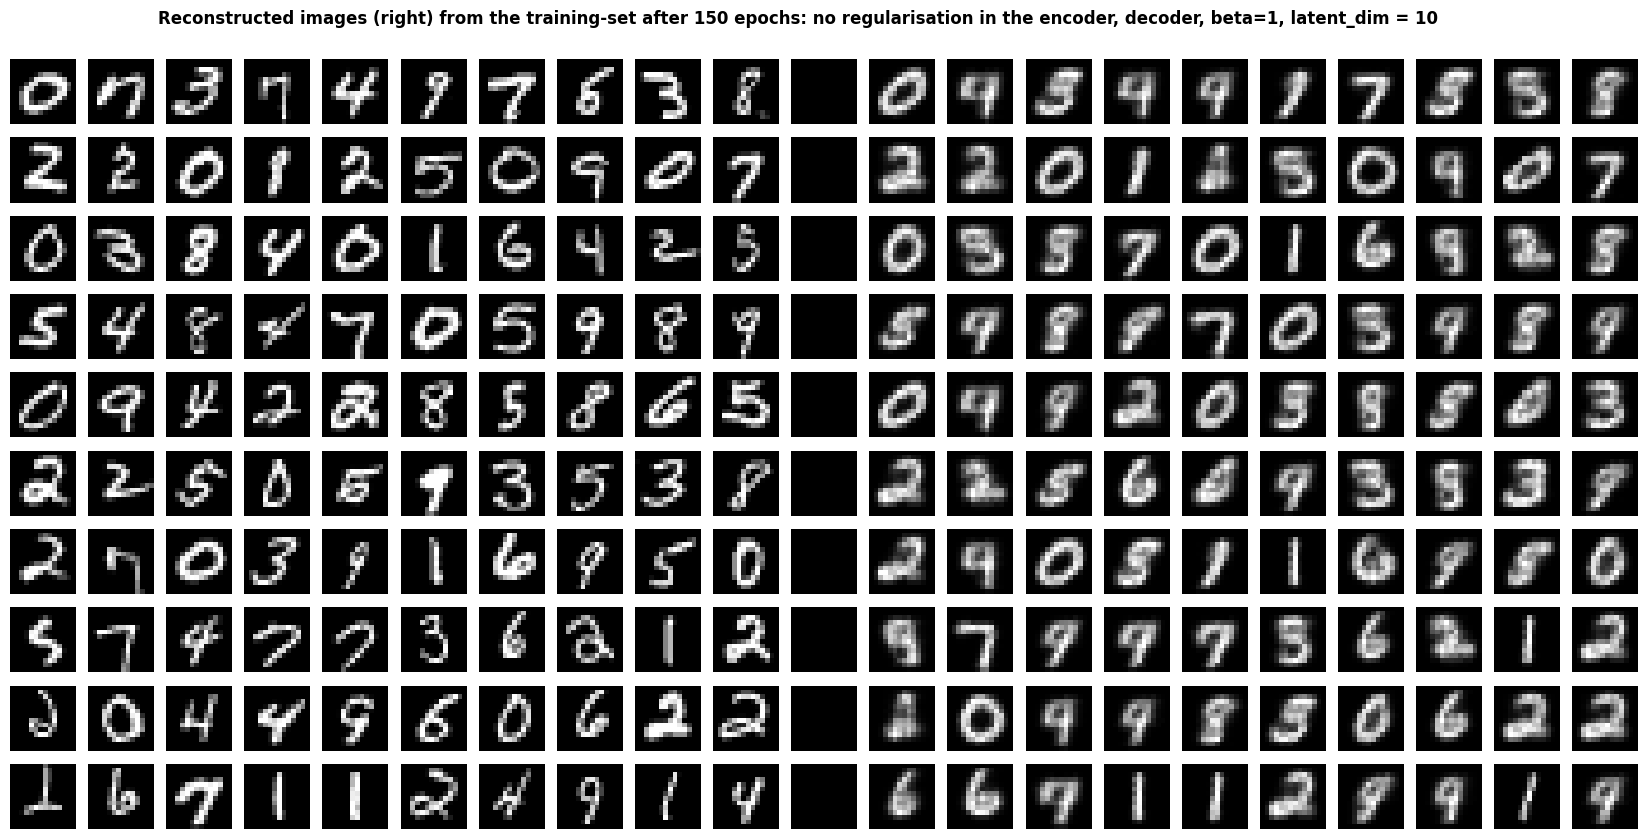

In [ ]:
plot_reconstruction(img_train,'training',500,150)

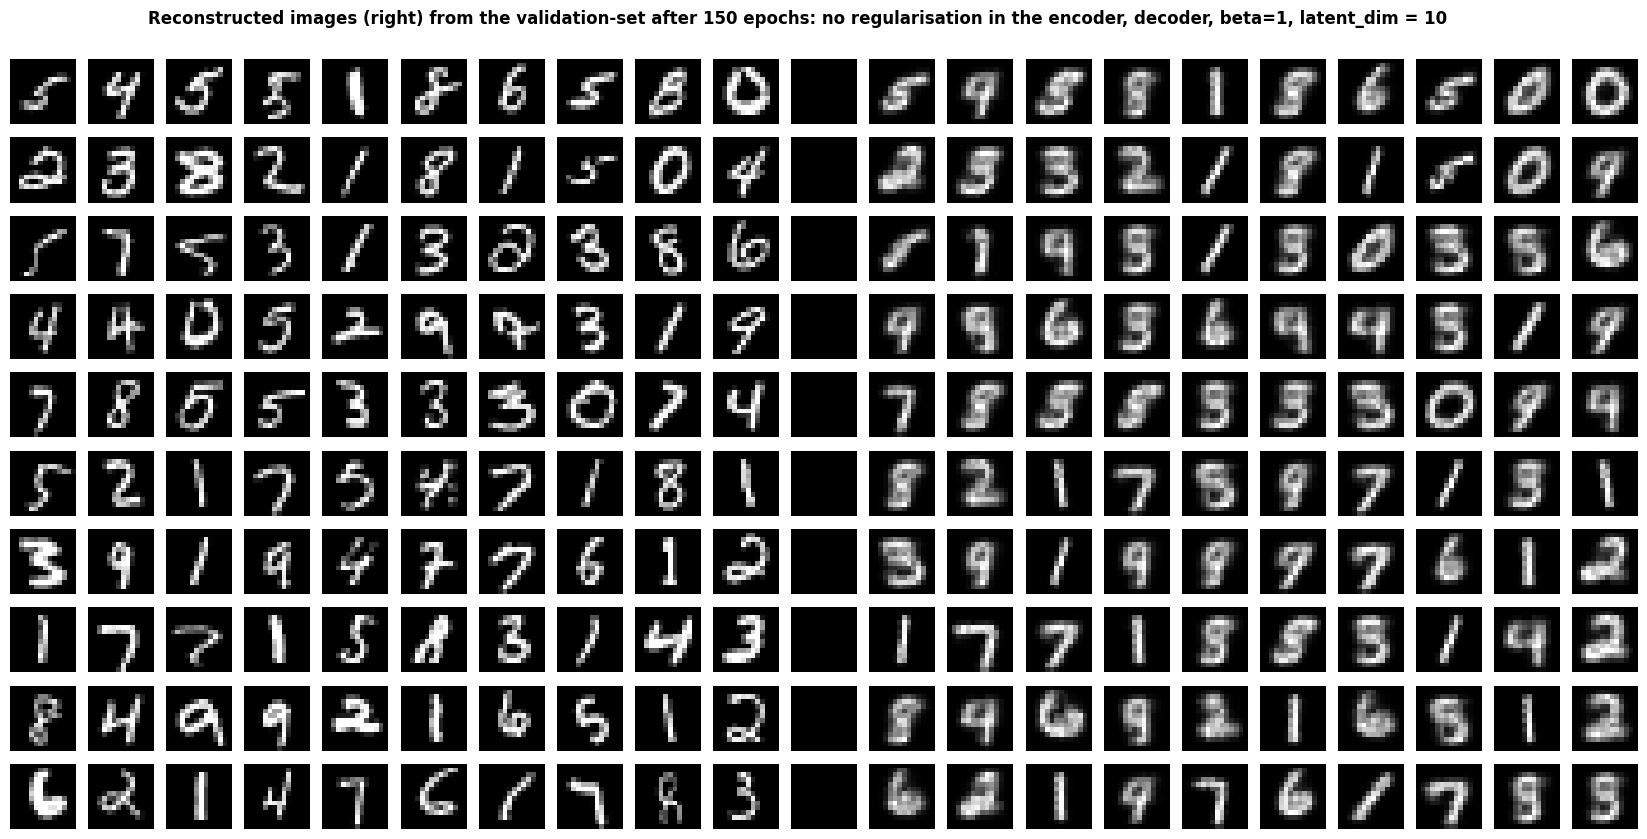

In [ ]:
plot_reconstruction(img_valid,'validation',1000,150)